# Install packages for Medical data analysis 

# Part I

In [1]:
import pydicom
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil

## Use DICOM library

In [7]:
# Use pydicom's dcmread method to load the image
dcm = pydicom.dcmread("instance.dcm")
print(f"Modality: {dcm.Modality}")

Modality: CT


In [8]:
# Use NumPy array by accessing .pixel_array field.
pixels = np.copy(dcm.pixel_array)
print(f"min: {np.min(pixels)}, max: {np.max(pixels)}")

min: -3024, max: 3071


min: 0.0, max: 0.644546332046332


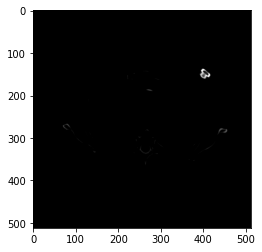

In [9]:
#Apply WW/WC transform and convert image into greyscale

wc = 2472
ww = 4144

hu_min = wc - ww/2
hu_max = wc + ww/2

pixels[np.where(pixels < hu_min)] = hu_min
pixels[np.where(pixels > hu_max)] = hu_max
pixels = (pixels - hu_min)/(hu_max-hu_min)

plt.imshow(pixels, cmap="gray")

print(f"min: {np.min(pixels)}, max: {np.max(pixels)}")

In [10]:
# save the image with PIL: Image.fromarray and .save methods to save a NumPy array as png
# used "L" mode, PIL is expecting your data to be of type uint8 (and in the range of 0-255)

out = (pixels*0xff).astype(np.uint8)
im = Image.fromarray(out, mode="L")
im.save("out.png")

## Part II

In [12]:
path = f"volume"
slices = [pydicom.dcmread(os.path.join(path, f)) for f in os.listdir(path)]
slices = sorted(slices, key = lambda dcm: dcm.ImagePositionPatient[0])

In [13]:
# What are the dimensions?
print(f"{len(slices)} of size {slices[0].Rows}x{slices[0].Columns}")

24 of size 320x260
Modality: MR
Pixel Spacing: [0.6875, 0.6875], slice thickness: 5


In [ ]:
# What is the modality? 
print(f"Modality: {slices[0].Modality}")

In [ ]:
# %%
# What is the slice spacing?
print(f"Pixel Spacing: {slices[0].PixelSpacing}, slice thickness: {slices[0].SliceThickness}")

In [14]:
# Load into numpy array
image_data = np.stack([s.pixel_array for s in slices])
print(image_data.shape)

(24, 320, 260)


Saving axial: 


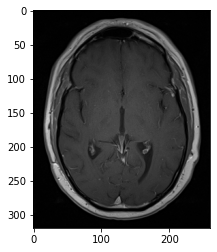

In [15]:
# %%
print("Saving axial: ")
# Extract slice
axial = image_data[image_data.shape[0]//2]
plt.imshow(axial, cmap="gray")
# Save using full-range window
im = Image.fromarray((axial/np.max(axial)*0xff).astype(np.uint8), mode="L")
im.save("axial.png")



Saving sagittal: 
(24, 320)


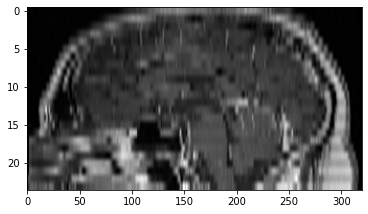

In [16]:
# %%
print("Saving sagittal: ")
# Extract slice
sagittal = image_data[:,:, image_data.shape[2]//2]
# Compute aspect ratio
aspect = slices[0].SliceThickness / slices[0].PixelSpacing[0]
print(sagittal.shape)
plt.imshow(sagittal, cmap="gray", aspect = aspect)
# Save using full-range window
im = Image.fromarray((sagittal/np.max(sagittal)*0xff).astype(np.uint8), mode="L")
im = im.resize((sagittal.shape[1], int(sagittal.shape[0] * aspect)))
im.save("sagittal.png")

Saving coronal: 
(24, 260)


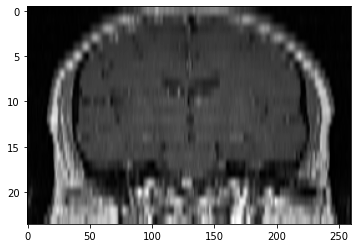

In [17]:
# %%
print("Saving coronal: ")
# Extract slice
coronal = image_data[:, image_data.shape[1]//2, :]
# Compute aspect ratio
aspect = slices[0].SliceThickness / slices[0].PixelSpacing[0]
print(coronal.shape)
plt.imshow(coronal, cmap="gray", aspect = aspect)
# Save using full-range window
im = Image.fromarray((coronal/np.max(coronal)*0xff).astype(np.uint8), mode="L")
im = im.resize((coronal.shape[1], int(coronal.shape[0] * aspect)))
im.save("coronal.png")



In [ ]:


# TASK: In the same folder as this .py file you will find a DICOM folder
# with a volume in it. You can assume that all files belong to the same series.
# Your task is to visualize any three slices across the three 
# cardinal planes from this volume: Axial, Coronal and Sagittal. You can visualize 
# by saving them as png, similar to the previous exercise. You can visualize slice at 
# any level, but I suggest that you visualize slices located in the middle of the volume.

# 
# Bonus points: 
# 1) What is the modality that you are dealing with here?
# 2) Try to figure out which axis corresponds to what plane by searching online.
# You should have a good guess of what anatomy you are looking at if you visualize the middle slice
# 3) Try plotting the slices in non-primary planes with proper aspect ratio
#
# Hints:
# - You may want to rescale the output because your voxels are non-square. 
# - Don't forget that you need to order your slices properly. Filename 
# may not be the best indicator of the slice order. 
# If you're confused, try looking up the first value of ImagePositionPatient
# - Don't forget the windowing. A good initial guess would be scaling all
# image values down to [0..1] range when saving. Pillow deals with such well

# %% 
# Load the volume into array of slices


# <YOUR CODE HERE>

Volume Dataset Analysis
In this exercise you will be analyzing a DICOM dataset. This dataset is not as conveniently organized on the filesystem as some of the datasets we have seen in this lesson so far. Rather, this dataset looks like something that you are likely to get as a raw dump from a clinical data archive.

Your task is to use the skills you have acquired in this lesson to go through this dataset and answer (or provide your best quess to) the following questions:

What imaging modality was used to produce this dataset?
Data from how many patients does the dataset include?
How many studies are in the dataset?
What are the oldest and the most recent studies in the dataset?
How many series are in the dataset?
In addition, do the following tasks:

List voxel dimensions of all 3D volumes (i.e. series) that the dataset contains as WxHxD
The dataset contains two outliers. Can you find them? There is more than one way to find them. Type up why do you think these volumes are outliers and what approach you used.
Lastly, I understand that you are not a radiologist quite yet, but as a stretch goal, do the following:

Load a few series into 3D slicer and tell what is the anatomy imaged in our dataset
You can assume that this dataset is consistent with DICOM information model, i.e. all instances within series share common attributes of the series and all instances within study share common study attributes. In other words, you can expect that something like Series Description will be the same for all instances belonging to the same series and you can read this value from any one file of the series. You can also expect that all the slices in same series have equal resolution and are evenly spaced.

## Part III : Volume Dataset Analysis

In [27]:
# Let's use the same code as in the walkthrough to load data

path = r"data"
dirs = np.array([[(os.path.join(dp, f), pydicom.dcmread(os.path.join(dp, f), stop_before_pixels = True)) for f in files]
                   for dp,_,files in os.walk(path) if len(files) != 0])

In [28]:
# How many directories?
len(dirs)

1

In [29]:
instances = dirs[0]
len(instances)

864

In [30]:
series_uids = np.unique([inst[1].SeriesInstanceUID for inst in instances])
len(series_uids)

32

In [31]:
studies_uids = np.unique([inst[1].StudyInstanceUID for inst in instances])
len(studies_uids)

10

In [32]:
patient_ids = [inst[1].PatientID for inst in instances]
print(patient_ids)

['PGBM-005', '123456', 'PGBM-009', 'PGBM-009', 'PGBM-009', 'PGBM-005', 'PGBM-004', 'PGBM-003', 'PGBM-009', '123456', 'PGBM-009', 'PGBM-005', 'PGBM-003', 'PGBM-004', 'PGBM-009', 'PGBM-009', 'PGBM-005', 'PGBM-004', 'PGBM-003', 'PGBM-003', 'PGBM-004', 'PGBM-009', 'PGBM-009', 'PGBM-005', 'PGBM-004', 'PGBM-003', 'PGBM-004', 'PGBM-005', '123456', 'PGBM-003', '123456', 'PGBM-005', '123456', '123456', '123456', 'PGBM-009', 'PGBM-005', 'PGBM-003', 'PGBM-005', '123456', 'PGBM-009', 'PGBM-004', '123456', '123456', '123456', '123456', 'PGBM-004', 'PGBM-009', 'OPA135179', '123456', 'PGBM-009', 'PGBM-005', 'PGBM-005', '123456', 'OPA135179', 'PGBM-009', 'PGBM-004', 'PGBM-005', 'PGBM-005', 'PGBM-009', '123456', 'PGBM-005', '123456', 'PGBM-005', 'PGBM-009', '123456', 'PGBM-009', 'PGBM-005', 'PGBM-004', 'PGBM-003', 'PGBM-009', 'PGBM-005', 'PGBM-009', 'PGBM-003', 'PGBM-003', 'PGBM-009', 'PGBM-004', 'PGBM-004', 'PGBM-005', '123456', 'PGBM-009', 'PGBM-004', 'PGBM-009', 'PGBM-004', 'PGBM-003', 'PGBM-009', '

In [33]:
patients_ids_uq = np.unique(patient_ids)
print(f"Number of patients: {len(patients_ids_uq)}, patient IDs: {patients_ids_uq}")

Number of patients: 6, patient IDs: ['123456' 'OPA135179' 'PGBM-003' 'PGBM-004' 'PGBM-005' 'PGBM-009']


In [34]:
series_uids_modality_map = {uid: s[1].Modality for uid in series_uids for s in instances if s[1].SeriesInstanceUID == uid }

In [35]:
series_uids_modality_map

{'1.2.826.0.1.3680043.2.1125.1.45859137663006505718300393375464286': 'CT',
 '1.3.12.2.1107.5.2.33.37105.2015011616025092819028166.0.0.0': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.105521800202421035670670758706': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.108708982094690934070899838243': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.111299569371716382165219422799': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.131971402732874033229609248302': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.137802635701410656176169562528': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.148342356080268980546237840587': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.149455479236394071679725178532': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.158869091666854803918782490935': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.165843183220097757648432257390': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.167613564536106399232524912048': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.7055.170099978014836890431312652906': 'MR',
 '1.3.6.1.4.1.14519.5.2.1.4429.

In [36]:
# First, load the pixel data - remember that we didn't load it for the sake of speed

slices_ct = [pydicom.dcmread(inst[0]) for inst in instances \
             if inst[1].SeriesInstanceUID == "1.2.826.0.1.3680043.2.1125.1.45859137663006505718300393375464286"]

slices_mr1 = [pydicom.dcmread(inst[0]) for inst in instances \
             if inst[1].SeriesInstanceUID == list(series_uids_modality_map.items())[4][0]]

slices_mr2 = [pydicom.dcmread(inst[0]) for inst in instances \
             if inst[1].SeriesInstanceUID == list(series_uids_modality_map.items())[9][0]]

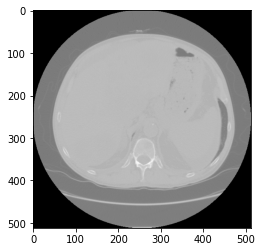

In [37]:
plt.imshow(slices_ct[10].pixel_array, cmap="gray")

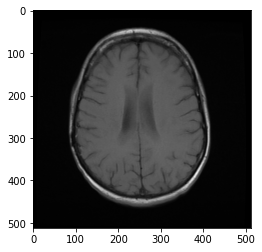

In [38]:
plt.imshow(slices_mr1[10].pixel_array, cmap="gray")

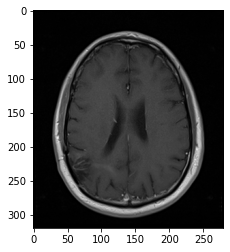

In [39]:
plt.imshow(slices_mr2[10].pixel_array, cmap="gray")